In [7]:
try:
    import cv2 as cv
    import matplotlib.pyplot as plt
    import numpy as np
    import imutils    

except ModuleNotFoundError:
    import subprocess
    import sys

    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    install('opencv-python')
    install('matplotlib')
    install('numpy')
    install('imutils')

    import cv2 as cv
    import matplotlib.pyplot as plt
    import numpy as np
    import imutils

# Segmentación 1

In [8]:
colors_dict = {
    'negro': [0, 0, 0],
    'blanco': [255, 255, 255],
    'rojo': [255, 0, 0],
    'verde': [0, 255, 0],
    'azul': [0, 0, 255],
    'amarillo': [255, 255, 0],
    'magenta': [255, 0, 255],
    'cian': [0, 255, 255]
}

La función R_measure calcula una medida denominada "R" a partir de una imagen dada:

In [9]:
def R_measure(image):

    norm_var = image.var()/255 # Obtenemos la varianza de la imagen y la normalizamos
    R = 1 - (1 / (1 + norm_var)) # Aplicamos la fórmula para calcular R a partir de la varianza normalizada

    return R

La función segment_car_by_color realiza la segmentación de un automóvil en función de un color específico en una imagen. Aquí se describen los pasos principales de la función:

 - Se imprime la medida "R" de la imagen utilizando la función R_measure.
 - Se define una función interna llamada get_mask que genera una máscara en función del color especificado.
 - Si el color especificado no está en el diccionario de colores (colors_dict), se retorna None.
 - Si la medida "R" de la imagen es menor que un umbral específico (r_measure), se retorna None.
 - Se convierte la imagen a formato RGB y se realiza una transformación de los valores de píxeles a una representación de punto flotante.
 - Se aplica el algoritmo de clustering K-means para encontrar los centros de los colores similares al objetivo.
 - Se crea una imagen segmentada donde cada píxel está etiquetado con el centro más cercano.
 - Se convierte la imagen segmentada a formato HSV.
 - Se calcula una máscara utilizando la función get_mask y se aplica a la imagen segmentada.
 - Se encuentran los contornos en la máscara y se selecciona el contorno más grande.
 - Se encuentra la caja delimitadora del contorno más grande y se devuelve la región recortada de la imagen original.
 - Si no se encuentran contornos, se retorna None.

In [10]:
def segment_car_by_color(image, color_name, hue_tolerance = 25, k = 10, r_measure = 0.92):

    print("Medida R de la imagen: " + str(R_measure(image)))
    
    def get_mask(target_color_hsv, hue_tolerance):

        if color_name.lower() == 'negro':
            lower = np.array([0, 0, 0])
            upper = np.array([179, 255, 50])
            full_mask = cv.inRange(hsv, lower, upper)
            return full_mask
        elif color_name.lower() == 'blanco':
            lower = np.array([0, 0, 200])
            upper = np.array([179, 30, 255])
            full_mask = cv.inRange(hsv, lower, upper)
            return full_mask
        elif color_name.lower() == 'gris':
            lower = np.array([0, 0, 100])
            upper = np.array([179, 30, 200])
            full_mask = cv.inRange(hsv, lower, upper)
            return full_mask
        
        lower_hue = target_color_hsv[0][0][0] - hue_tolerance
        upper_hue = target_color_hsv[0][0][0] + hue_tolerance
            
        if lower_hue < 0:
            lower1 = np.array([0, 100, 100])
            upper1 = np.array([upper_hue, 255, 255])
            
            lower2 = np.array([179 + lower_hue, 100, 100])
            upper2 = np.array([179, 255, 255])
            
            lower_mask = cv.inRange(hsv, lower1, upper1)
            upper_mask = cv.inRange(hsv, lower2, upper2)
            full_mask = lower_mask + upper_mask
            
        elif upper_hue > 179:
            
            lower1 = np.array([0, 100, 100])
            upper1 = np.array([upper_hue - 179, 255, 255])
            
            lower2 = np.array([lower_hue, 100, 100])
            upper2 = np.array([179, 255, 255])
            
            lower_mask = cv.inRange(hsv, lower1, upper1)
            upper_mask = cv.inRange(hsv, lower2, upper2)
            full_mask = lower_mask + upper_mask
            
            
        else: # lower_hue >= 0 and upper_hue <= 179
        
            lower = np.array([lower_hue, 100, 100])
            upper = np.array([upper_hue, 255, 255])
            full_mask = cv.inRange(hsv, lower, upper)
            
        return full_mask
    
    # Si color_name no está en el diccionario in colors_dict
    if color_name.lower() not in colors_dict:
        return None
    
    # Si la imagen is muy similar al fondo
    if R_measure(image) < r_measure:    
        return None

    target_color = colors_dict[color_name.lower()]
    
    # Convertir la imagen a RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Convertir la imagen a valores de píxeles individuales
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Realizar K-means clustering para encontrar los centros de los colores similares al objetivo
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    _, labels, (centers) = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    # Convertir los centros a enteros sin signo de 8 bits y aplanar las etiquetas
    centers = np.uint8(centers)
    labels = labels.flatten()

    # Crear una imagen segmentada donde cada píxel está etiquetado con el centro más cercano
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    # Convertir la imagen segmentada a HSV
    hsv = cv.cvtColor(segmented_image, cv.COLOR_RGB2HSV)

    # Definir los límites superior e inferior del color objetivo en HSV
    target_color_hsv = cv.cvtColor(np.uint8([[target_color]]), cv.COLOR_RGB2HSV)

    full_mask = get_mask(target_color_hsv, hue_tolerance)
    
    # Aplicar la máscara a la imagen original
    masked_image = cv.bitwise_and(segmented_image, segmented_image, mask=full_mask)
    
    contours, _ = cv.findContours(full_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        # Encontrar la caja delimitadora del contorno más grande y devolver la región recortada de la imagen original
        x, y, w, h = cv.boundingRect(largest_contour)
        return segmented_image, masked_image, largest_contour, image[y:y+h, x:x+w]
    else:
        return None

La función **plot_car_segmentation_images** carga una imagen de un automóvil y la segmenta en función de un color específico. Luego, muestra diferentes imágenes relacionadas con la segmentación, como la imagen original del automóvil, la imagen segmentada, la imagen con una máscara aplicada, el contorno más largo dibujado en el automóvil y la región resultante de la segmentación. En caso de que el color especificado no se encuentre en la imagen, se muestra un mensaje de error y se muestra solo la imagen original del automóvil.

In [11]:
def plot_car_segmentation_images(image, color, line_color = "verde"):

    car = cv.imread(image)

    car_region = segment_car_by_color(car, color)

    plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = 0.5)

    if(car_region[0] is not None):

        c_ls = colors_dict[line_color.lower()]

        fig, axs = plt.subplots(3, 2, figsize=(15, 10))
        plt.subplot(3, 2, 1)
        plt.title("Imagen original")
        plt.imshow(cv.cvtColor(car, cv.COLOR_BGR2RGB))
        plt.subplot(3, 2, 2)
        plt.title("Imagen segmentada")
        plt.imshow(car_region[0])
        plt.subplot(3, 2, 3)
        plt.title("Imagen tras aplicar máscara")
        plt.imshow(car_region[1])
        plt.subplot(3, 2, 4)
        plt.title("Imagen con contorno más largo")
        plt.imshow(cv.cvtColor(cv.drawContours(car, car_region[2], -1, (c_ls[0], c_ls[1], c_ls[2]), 3), cv.COLOR_BGR2RGB))
        plt.subplot(3, 1, 3)
        plt.title("Región resultante")
        plt.imshow(car_region[3])

    else:
        print("No se encontró el color especificado en la imagen")
        plt.title("Imagen original")
        plt.imshow(cv.cvtColor(car, cv.COLOR_BGR2RGB))

## Pruebas experimentales - Segmentación 1

Medida R de la imagen: 0.9581857515696701


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\2230094538.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


<Figure size 640x480 with 0 Axes>

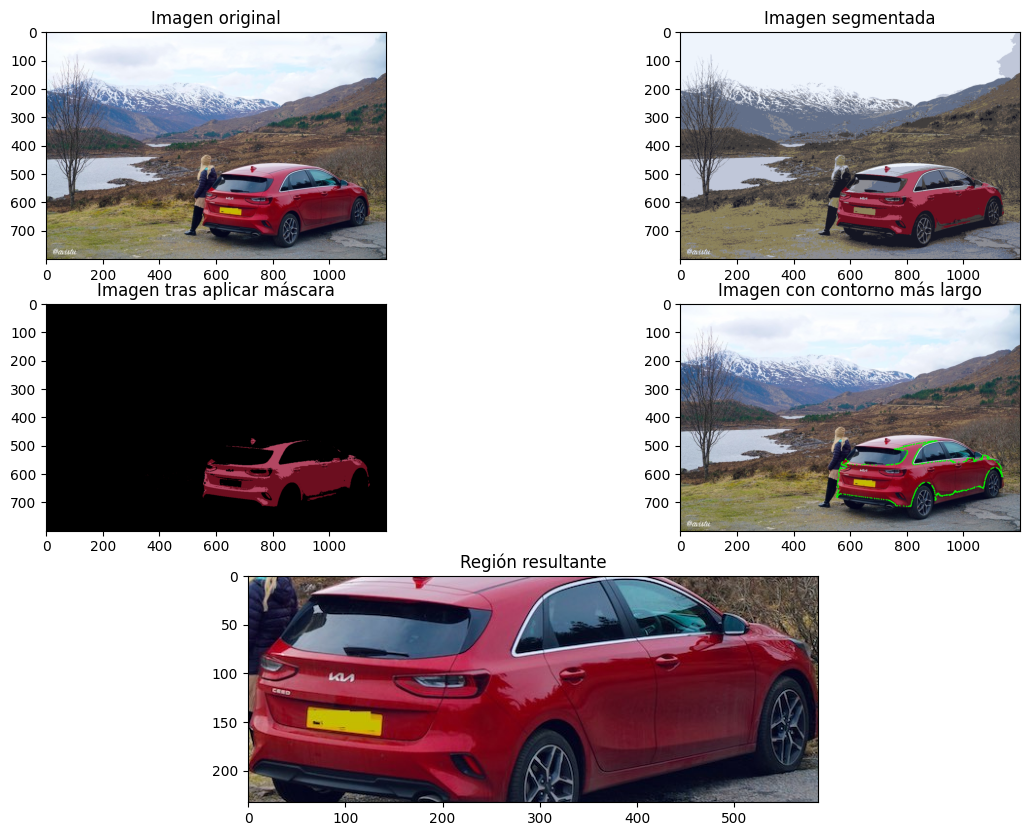

In [12]:
# Red car
plot_car_segmentation_images("images/red_car.jpg", "rojo")

Medida R de la imagen: 0.9286892537413977


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\2230094538.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


<Figure size 640x480 with 0 Axes>

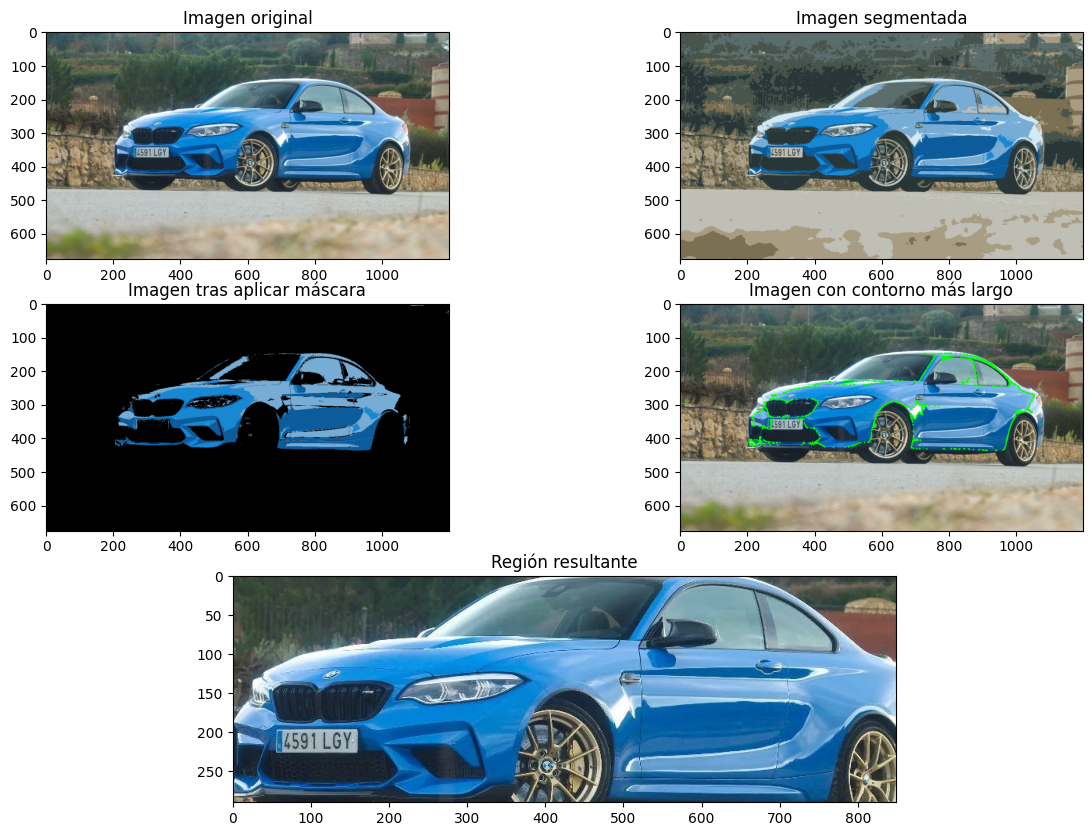

In [13]:
# Blue car
plot_car_segmentation_images("images/blue_car.webp", "azul")

Medida R de la imagen: 0.9377738667664254


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\2230094538.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


<Figure size 640x480 with 0 Axes>

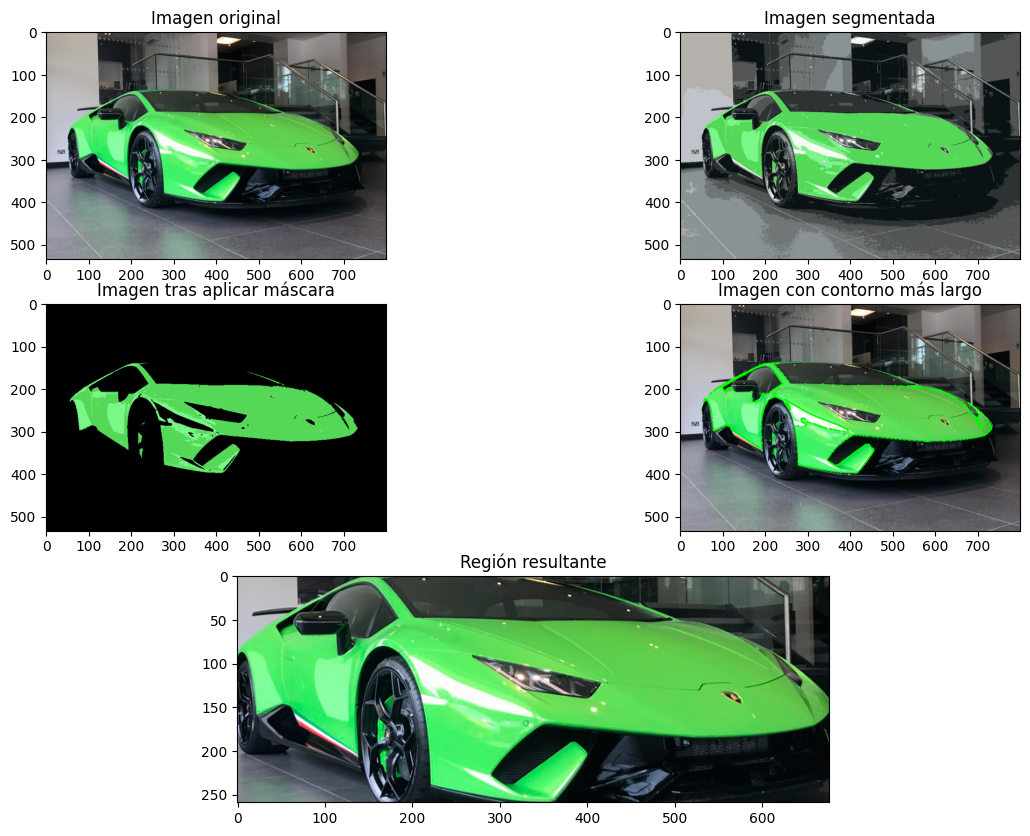

In [14]:
# Green car
plot_car_segmentation_images("images/green_car.jpg", "verde")

Medida R de la imagen: 0.9600751056118564


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\2230094538.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


<Figure size 640x480 with 0 Axes>

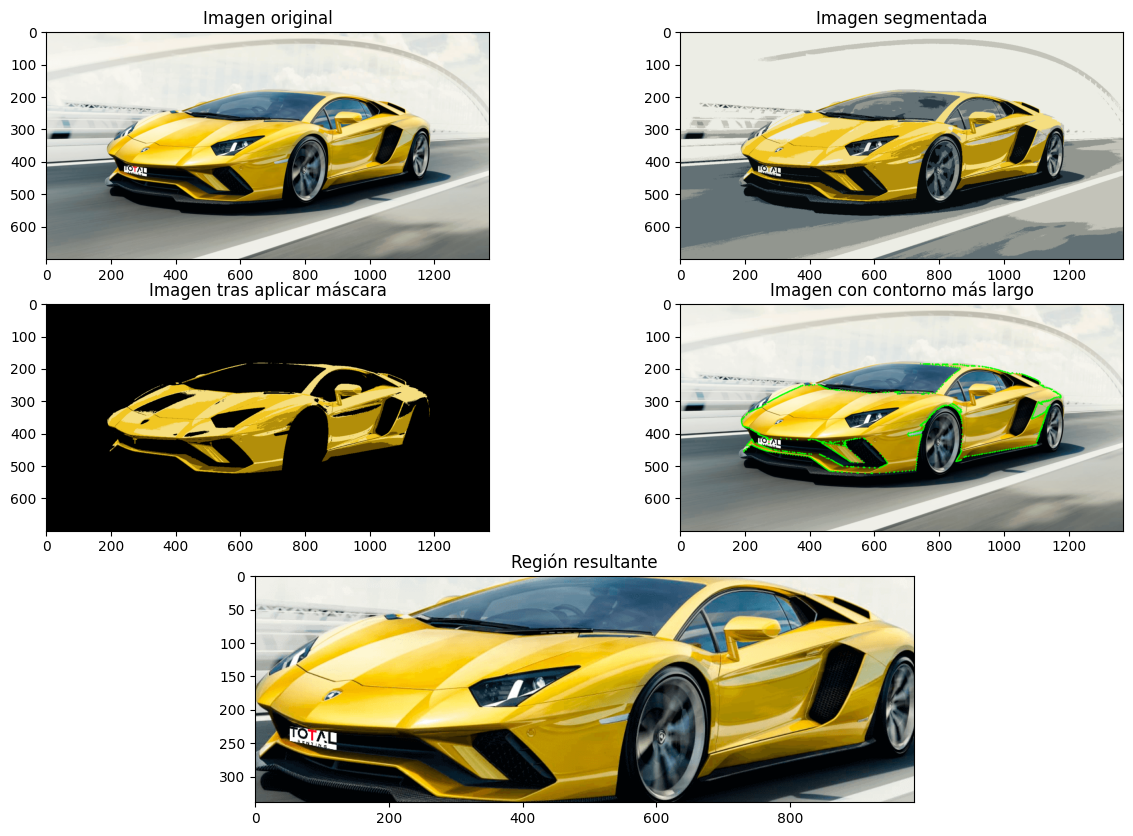

In [15]:
# Yellow car
plot_car_segmentation_images("images/yellow_car.png", "amarillo")

Medida R de la imagen: 0.9396987036003309


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\2230094538.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)


<Figure size 640x480 with 0 Axes>

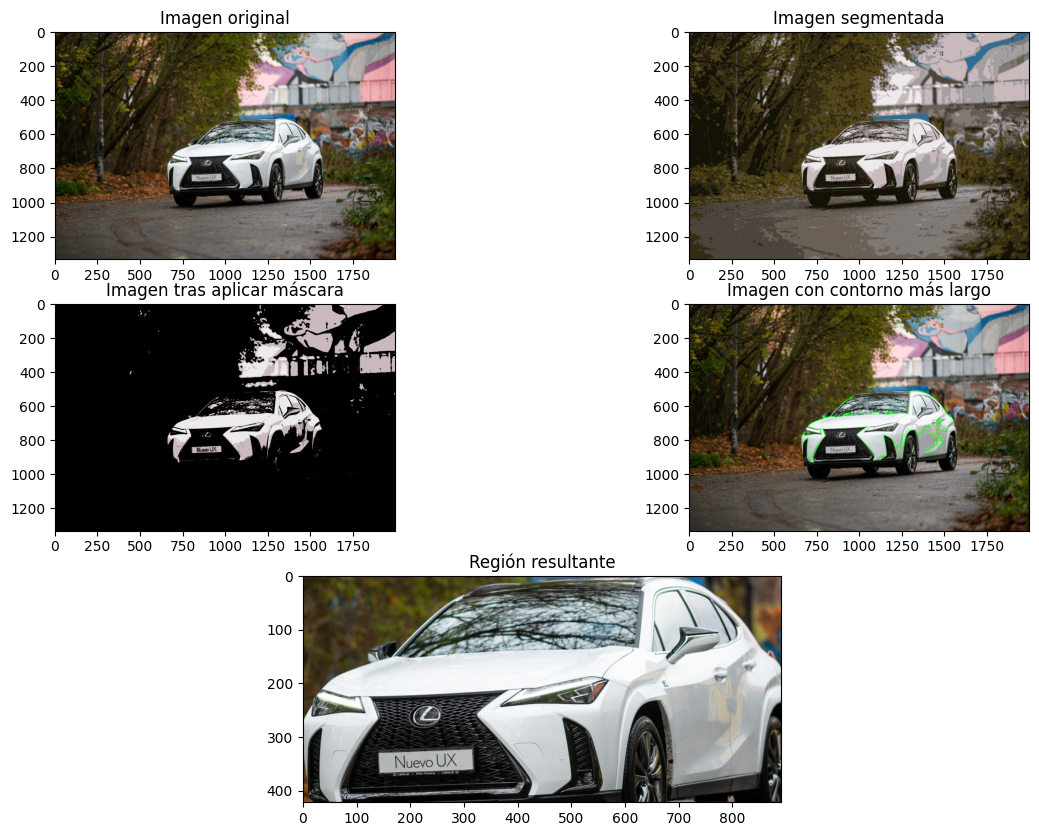

In [16]:
# White car
plot_car_segmentation_images("images/utiles/15.jpg", "blanco")

# Segmentación 2

La función toma una imagen como entrada y realiza los siguientes pasos:

- Convierte la imagen en escala de grises.
- Aplica un filtro bilateral para suavizar la imagen mientras mantiene los bordes.
- Utiliza el algoritmo de detección de bordes Canny para detectar los bordes de la imagen.
- Busca los contornos en la imagen utilizando la función cv.findContours().
- Selecciona los diez contornos más grandes en orden descendente.
- Itera a través de los contornos y aplica una aproximación poligonal a cada uno utilizando la función cv.approxPolyDP().
- Si la aproximación poligonal tiene cuatro puntos, se asume que el contorno representa la matrícula y se almacena en la variable screenCnt.
- Crea una máscara en blanco de la misma forma y tamaño que la imagen original.
- Dibuja el contorno de la matrícula en la máscara utilizando la función cv.drawContours().
- Utiliza la máscara para extraer la matrícula de la imagen original mediante la operación bitwise "AND" con la función cv.bitwise_and().
- Muestra la imagen resultante utilizando la biblioteca matplotlib.

In [17]:
def detect_car_brand(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = cv.bilateralFilter(gray, 13, 15, 15)
    edged = cv.Canny(gray, 30, 200)
    contours=cv.findContours(edged.copy(),cv.RETR_TREE,
                                                cv.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours,key=cv.contourArea, reverse = True)[:10]
    screenCnt = None
    value = False

    for c in contours:
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.018 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            value = True
            break
            
    if not value:
        print("No se ha encontrado ninguna matrícula")
        return None
    
    x,y,w,h = cv.boundingRect(screenCnt)
    
    car_registration = img[y:y+h, x:x+w]
    upper_region = img[y-h-h-h:y, x:x+w]
    
    return img, car_registration, upper_region

La función **plot_car_brand_images** carga una imagen de un automóvil y detecta su marca. Luego, muestra la imagen original junto a la región de dicha imagen que contiene la marca.

In [18]:
def plot_car_brand_images(image):
    
    img, car_registration, upper_region = detect_car_brand(image)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.title("Imagen original")
    plt.imshow(img)
    plt.subplot(2, 2, 2)
    plt.title("Región de matrícula")
    plt.imshow(car_registration)
    plt.subplot(2, 1, 2)
    plt.title("Región de marca")
    plt.imshow(upper_region)

## Pruebas experimentales - Segmentación 2

In [19]:
#White car

white_car_2 = cv.imread("images/utiles/15.jpg")
_,_,_, white_car_segmented = segment_car_by_color(white_car_2, "blanco")

Medida R de la imagen: 0.9396987036003309


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\334250653.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


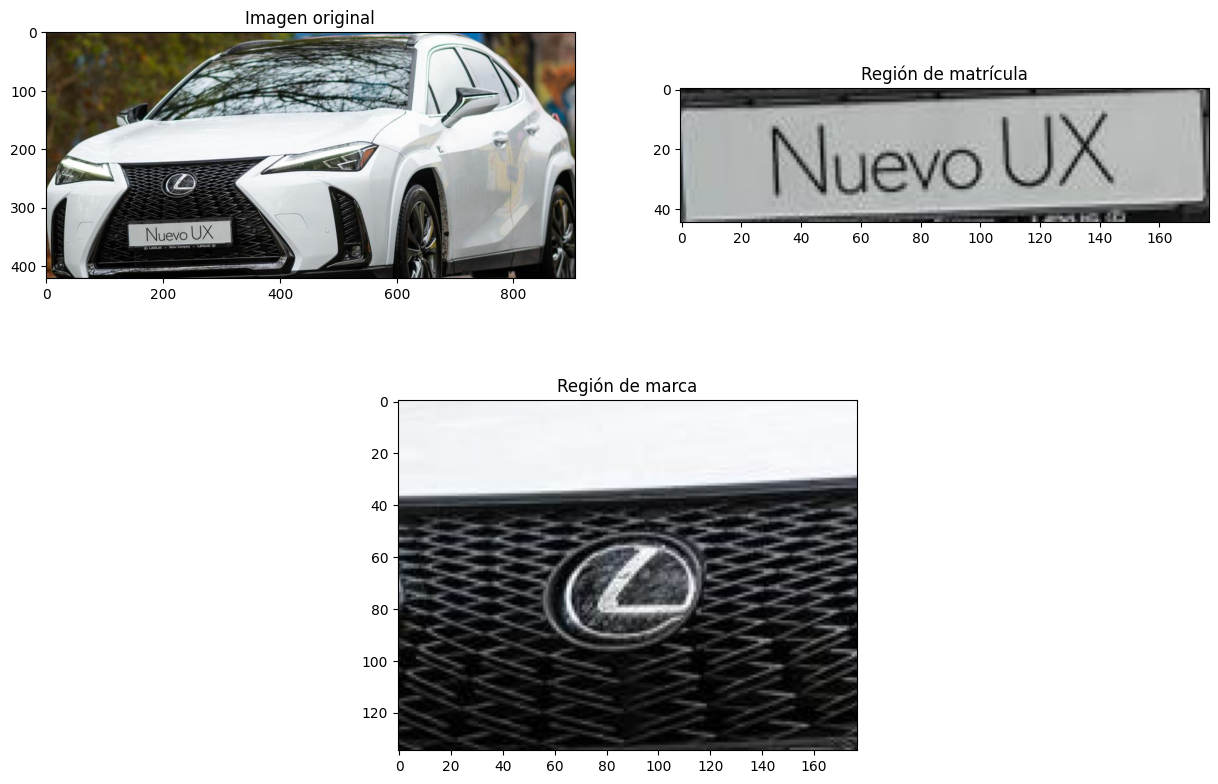

In [20]:
plot_car_brand_images(white_car_segmented)

In [21]:
#Red car

red_car_2 = cv.imread("images/red_car.jpg")
_,_,_, red_car_segmented = segment_car_by_color(red_car_2, "rojo")

Medida R de la imagen: 0.9581857515696701


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\334250653.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


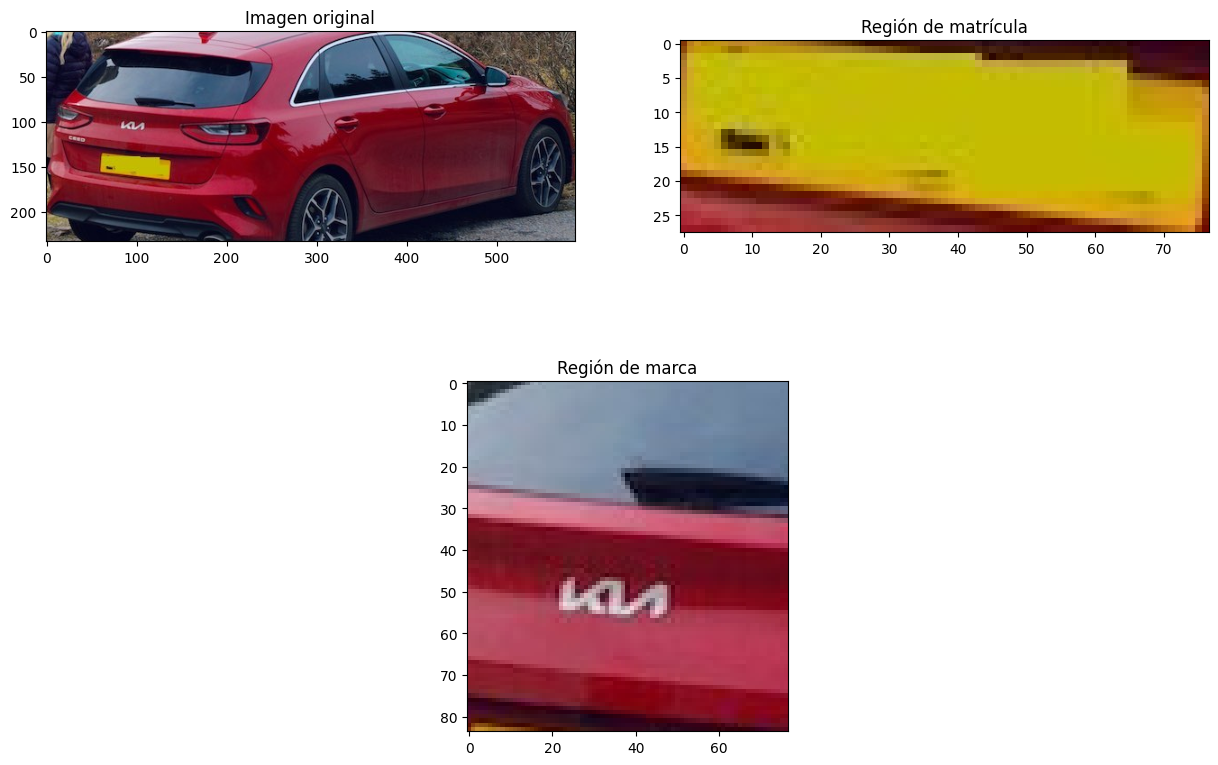

In [22]:
plot_car_brand_images(red_car_segmented)

In [23]:
# Yellow car

yellow_car_2 = cv.imread("images/utiles/audi_amarillo.jpg")
_,_,_, yellow_car_segmented = segment_car_by_color(yellow_car_2, "amarillo")

Medida R de la imagen: 0.9656377058335455


C:\Users\ismae\AppData\Local\Temp\ipykernel_2380\334250653.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


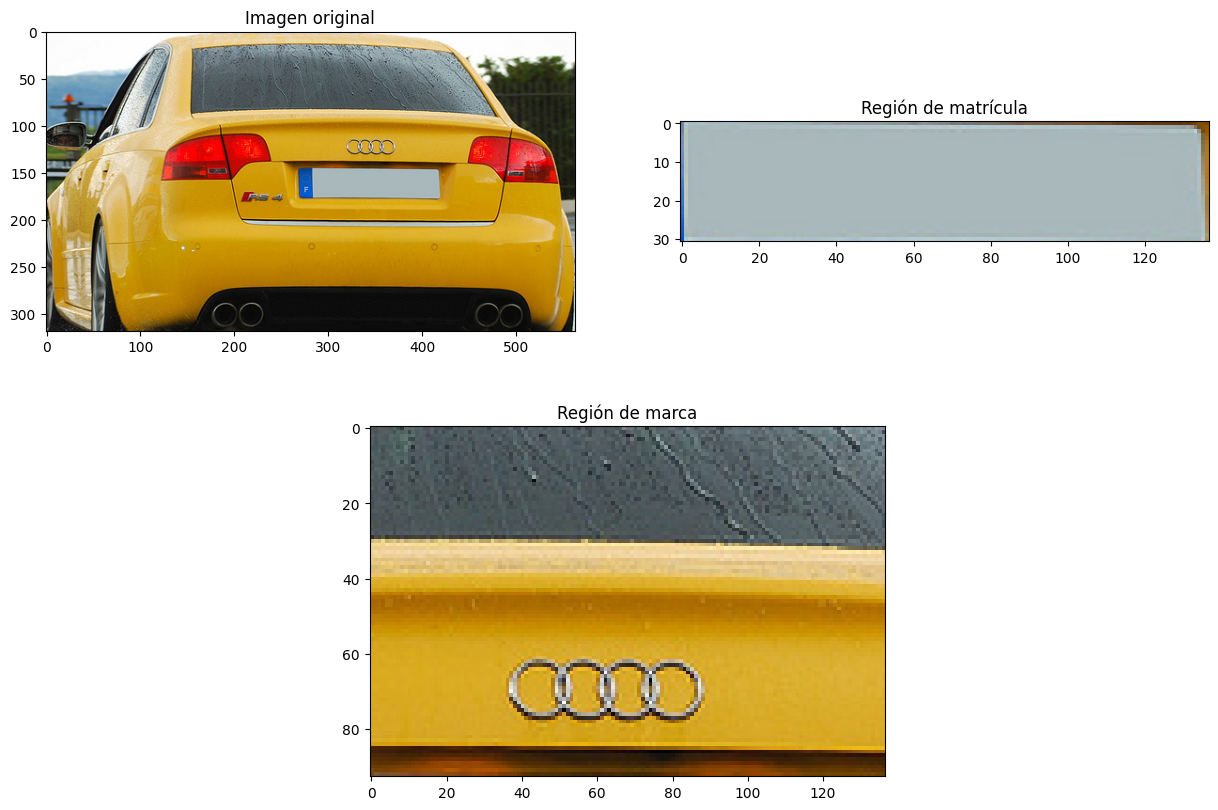

In [24]:
plot_car_brand_images(yellow_car_segmented)